# 2.4 线性模型和全连接神经网络

在本节，我们会介绍一种最基本的神经网络模型，全连接神经网络，其实在之前的几节，我们所实现的就是全连接神经网络，但是在本节我们会用pytorch的风格实现Module类，实现更方便的构建模型的函数，同时我们会介绍何为欠拟合，过拟合，以及一些消除欠拟合过拟合的方法。

我们首先把我们在张量这几节中实现的内容放到一个py文件中，方便我们之后的调用

In [1]:
import sys
sys.path.append('.')

In [2]:
from mytorch import Tensor

我们先实现Module类，这个类会是所有模型的夫类，主要实现了模型结构的定义，参数的初始化，同时记录和追踪模型的参数变化，当你没有定义模型前向传播的方法的时候，会报错，因为python中没有借口，我们用raise来表示，让每个子类保证实现了forward方法，同时我们希望这个类的实例被调用时，自带运行forward来求解，所以实现了\_\_call\_\_方法

In [ ]:
class Module:
    def __init__(self):
        self._parameters = {}
        self._modules = {}
    def forward(self, *input):
        raise NotImplementedError
    def __call__(self, *input):
        return self.forward(*input)

我们来实现一个简单的线性模型，测试我们的Module类

In [7]:
import numpy as np
class Linear(Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.w = Tensor.from_numpy(np.random.rand(in_features, out_features))
        self.b = Tensor.from_numpy(np.random.rand(1, out_features))
    
    def forward(self, x):
        return x*self.w+self.b

In [30]:
in_features = 10
out_features = 5

linear_layer = Linear(in_features, out_features)
x = Tensor.from_numpy(np.random.rand(1, in_features))
output = linear_layer(x)

print(output)

Tensor(data=[[3.42376874 3.12571958 2.25732465 2.44523259 2.78703212]], grad=[[0. 0. 0. 0. 0.]], trainable=True)


现在我们希望实现named_parameters方法，这个方法会记录这个模型的各层的形状和数值

\_\_setattr\_\_ 是一个特殊方法（或称魔术方法）在 Python 中，用于拦截对对象属性的赋值操作。当你试图给对象的一个属性赋值时，这个方法会被自动调用。

In [24]:
class PositiveNumber:
    def __init__(self, initial_value):
        self.value = initial_value

    def __setattr__(self, name, value):
        if name == 'value' and value < 0:
            raise ValueError("Value must be positive")
        object.__setattr__(self, name, value)

obj = PositiveNumber(5)
obj.value = -10  # 这会触发 ValueError

ValueError: Value must be positive

我们会用\_\_setattr\_\_及时更新parameters和modules列表，然后通过调用named_parameters打印参数列表

 object.\_\_setattr\_\_(self, name, value) 用于在对象中设置一个属性。在 Python 中，当我们为一个对象设置属性时，如 self.attribute = value，实际上是在调用该对象的 \_\_setattr\_\_ 方法。但在我们自定义的 \_\_setattr\_\_ 方法中，如果直接使用 self.attribute = value，这会再次触发 \_\_setattr\_\_，从而导致无限递归。为了避免这种情况，在自定义的 \_\_setattr\_\_ 方法中设置属性时，我们应该使用基类（在这种情况下是 object 类）的 \_\_setattr\_\_ 方法。这样做可以直接在对象上设置属性，而不会再次触发 \_\_setattr\_\_。

In [37]:
class Module:
    def __init__(self):
        self._parameters = {}
        self._modules = {}

    def forward(self, *input):
        raise NotImplementedError

    def __call__(self, *input):
        return self.forward(*input)

    def named_parameters(self, memo=None, prefix=''):
        if memo is None:
            memo = set()

        for name, param in self._parameters.items():
            if param not in memo:
                memo.add(param)
                yield prefix + name, param

        for name, mod in self._modules.items():
            submodule_prefix = prefix + name + '.'
            for name, param in mod.named_parameters(memo, submodule_prefix):
                yield name, param

    def add_module(self, name, module):
        if not isinstance(module, Module) and module is not None:
            raise TypeError("{} is not a Module subclass".format(type(module)))
        self._modules[name] = module

    def __setattr__(self, name, value):
        if isinstance(value, Tensor):
            object.__setattr__(self, name, value)  # 先设置属性
            self._parameters[name] = value          # 然后添加到参数字典中
        elif isinstance(value, Module):
            self.add_module(name, value)
        else:
            object.__setattr__(self, name, value)


我们再来测试一下Linear这个类的参数列表

In [41]:
class Linear(Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.w = Tensor.from_numpy(np.random.rand(in_features, out_features))
        self.b = Tensor.from_numpy(np.random.rand(1, out_features))
    
    def forward(self, x):
        return x*self.w+self.b

In [35]:
for name, parameter in linear_layer.named_parameters():
    print(name, parameter)

w Tensor(data=[[0.28560691 0.8672992  0.88595457 0.11899527 0.80321621]
 [0.33203469 0.50307607 0.952864   0.36840301 0.2706384 ]
 [0.97381182 0.42024134 0.49264617 0.38794506 0.59529725]
 [0.08387362 0.30237794 0.26447564 0.93845391 0.16128597]
 [0.40830442 0.53959658 0.50127377 0.21927836 0.40006681]
 [0.58827379 0.74123641 0.43745427 0.13590099 0.01242012]
 [0.43069382 0.59793469 0.20412198 0.08868851 0.90757201]
 [0.90974848 0.84735987 0.02955181 0.62218034 0.69052233]
 [0.86024293 0.16520478 0.07021213 0.7879401  0.93634434]
 [0.51618515 0.21954381 0.40886429 0.09486535 0.58629152]], grad=[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]], trainable=True)
b Tensor(data=[[0.53476514 0.53942268 0.36438901 0.44903074 0.13865316]], grad=[[0. 0. 0. 0. 0.]], trainable=True)


In [38]:
print(linear_layer)

Module()


现在，我们完成\_\_repr\_\_方法，来自动打印模型的网络结构

In [3]:
class Module:
    def __init__(self):
        self._parameters = {}
        self._modules = {}

    def forward(self, *input):
        raise NotImplementedError

    def __call__(self, *input):
        return self.forward(*input)

    def named_parameters(self, memo=None, prefix=''):
        if memo is None:
            memo = set()

        for name, param in self._parameters.items():
            if param not in memo:
                memo.add(param)
                yield prefix + name, param

        for name, mod in self._modules.items():
            submodule_prefix = prefix + name + '.'
            for name, param in mod.named_parameters(memo, submodule_prefix):
                yield name, param

    def add_module(self, name, module):
        if not isinstance(module, Module) and module is not None:
            raise TypeError("{} is not a Module subclass".format(type(module)))
        self._modules[name] = module

    def __setattr__(self, name, value):
        if isinstance(value, Tensor):
            object.__setattr__(self, name, value)  # 先设置属性
            self._parameters[name] = value          # 然后添加到参数字典中
        elif isinstance(value, Module):
            object.__setattr__(self, name, value)
            self.add_module(name, value)
        else:
            object.__setattr__(self, name, value)

    def __repr__(self):
        lines = [self.__class__.__name__ + '(']
        for name, module in self._modules.items():
            mod_str = repr(module).replace('\n', '\n  ')
            lines.append(f"  ({name}): {mod_str}")
        lines.append(')')
        return '\n'.join(lines)
    

接下来我们再对Linear类进行简单的修改，让其变成我们的标准模型类

In [8]:
class Linear(Module):
    def __init__(self, in_features, out_features, bias = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.w = Tensor.from_numpy(np.random.rand(in_features, out_features))
        if bias:
            self.b = Tensor.from_numpy(np.random.rand(1, out_features))
    
    def forward(self, x):
        return x*self.w+self.b if self.bias else x*self.w
    
    def __repr__(self):
        return f"Linear(in_features={self.in_features}, out_features={self.out_features}, bias={self.bias})"

In [9]:
l = Linear(5,6)

In [10]:
l(Tensor.from_numpy(np.random.rand(1, 5)))

Tensor(data=[[0.81330898 1.05057424 1.38959737 1.19471005 1.97466068 1.53463671]], grad=[[0. 0. 0. 0. 0. 0.]], trainable=True)

In [19]:
print(l)

Linear(in_features=5, out_features=6, bias=True)


In [5]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.l1 = Linear(5,6)
        self.l2 = Linear(6,8)
        self.l3 = Linear(8,2)
    
    def forward(self, x):
        x = self.l1(x)
        x = x.relu()
        x = self.l2(x)
        x = x.relu()
        x = self.l3(x)
        return x

In [10]:
net = Net()

In [12]:
net(Tensor.from_numpy(np.random.rand(1, 5)))

Tensor(data=[[12.79896658 18.67358734]], grad=[[0. 0.]], trainable=True)

In [13]:
print(net)

Net(
  (l1): Linear(in_features=5, out_features=6, bias=True)
  (l2): Linear(in_features=6, out_features=8, bias=True)
  (l3): Linear(in_features=8, out_features=2, bias=True)
)


最后，让我们摩饭pytorch风格，实现MSELoss类做一个收尾

In [24]:
class MSELoss(Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        loss = 0
        for i in range(len(target)):
            loss += (pred[i] - target[i]) ** 2
        return loss/len(target)


我们实现随机批次类，我们会在每个epoch开始的时候随机打乱整个数据集，再按批次大小从中取数，知道取完再开始下一个循环的随机打乱

In [27]:
class BatchSampler:
    def __init__(self, train_x, train_y, batch_size):
        self.train_x = train_x
        self.train_y = train_y
        self.batch_size = batch_size
        self.indices = np.arange(len(self.train_x))
        np.random.shuffle(self.indices)  # Shuffle at the start
        self.current_index = 0

    def next_batch(self):
        if self.current_index + self.batch_size > len(self.train_x):
            # Reshuffle the indices and reset the current index
            np.random.shuffle(self.indices)
            self.current_index = 0

        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        self.current_index += self.batch_size
        return self.train_x[batch_indices], self.train_y[batch_indices]

最后，让我们简单测试一下我们的程序

In [15]:
def func(x):
    return 4*x*x - 5

import numpy as np
x_values = np.linspace(-10, 10, 100)
y_values = func(x_values)

# Randomly choosing training data
random_indices = np.random.choice(len(x_values), size=80, replace=False)
train_x = x_values[random_indices]
train_y = y_values[random_indices]

# The remaining data can be considered as the testing dataset
test_x = np.delete(x_values, random_indices)
test_y = np.delete(y_values, random_indices)

In [22]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.l1 = Linear(1,10)
        self.l2 = Linear(10,1)
    
    def forward(self, x):
        x = self.l1(x)
        x = x.relu()
        x = self.l2(x)
        return x

In [23]:
net = Net()
net(12)

Tensor(data=[[24.96495613]], grad=[[0.]], trainable=True)

In [25]:
epoch = 30000
t = 0
mse_loss = MSELoss()
for i in range(epoch):
    loss = mse_loss([net(x) for x in train_x], train_y)
    loss.backward()
    t = loss.adam_opt(t, learning_rate=0.001)
    if i % 100 == 0:
        print(f'Epoch {i}/{epoch}, Loss: {loss}')

Epoch 0/30000, Loss: Tensor(data=[[26729.37141054]], grad=0, trainable=True)
Epoch 100/30000, Loss: Tensor(data=[[25864.72083901]], grad=0, trainable=True)
Epoch 200/30000, Loss: Tensor(data=[[24781.41256319]], grad=0, trainable=True)
Epoch 300/30000, Loss: Tensor(data=[[23525.79243365]], grad=0, trainable=True)
Epoch 400/30000, Loss: Tensor(data=[[22167.15960628]], grad=0, trainable=True)
Epoch 500/30000, Loss: Tensor(data=[[20785.49761644]], grad=0, trainable=True)
Epoch 600/30000, Loss: Tensor(data=[[19457.35929128]], grad=0, trainable=True)
Epoch 700/30000, Loss: Tensor(data=[[18242.58115979]], grad=0, trainable=True)
Epoch 800/30000, Loss: Tensor(data=[[17174.78401135]], grad=0, trainable=True)
Epoch 900/30000, Loss: Tensor(data=[[16258.30128231]], grad=0, trainable=True)
Epoch 1000/30000, Loss: Tensor(data=[[15471.91651013]], grad=0, trainable=True)
Epoch 1100/30000, Loss: Tensor(data=[[14779.9219655]], grad=0, trainable=True)
Epoch 1200/30000, Loss: Tensor(data=[[14144.70130823]

In [26]:
import matplotlib.pyplot as plt

def draw(forward_func, test_x, test_y):
    # 创建绘图
    plt.figure(figsize=(10, 6))

    # 绘制 forward 函数的曲线
    line_x = np.linspace(min(test_x), max(test_x), 100)
    line_y = [forward_func(x).data[0][0] for x in line_x]
    plt.plot(line_x, line_y, label="Forward Function", color='blue')

    # 绘制测试集的点
    plt.scatter(test_x, test_y, label="Test Data", color='red')

    # 添加图例和标签
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Forward Function vs Test Data')
    plt.legend()

    # 显示图形
    plt.show()

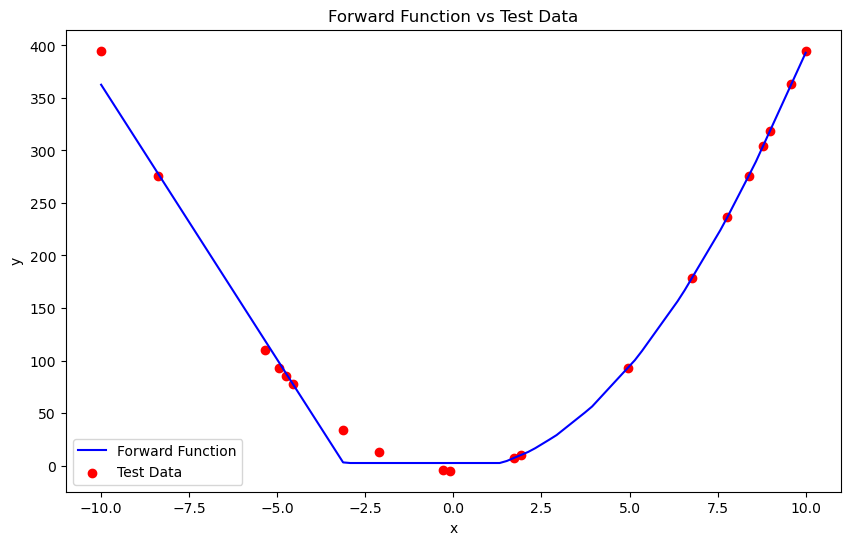

In [27]:
draw(net, test_x, test_y)

In [51]:
epoch = 30000
batch_size = 80
batch_sampler = BatchSampler(train_x, train_y, batch_size)
mse_loss = MSELoss()
t = 0
for i in range(epoch):
    loss_sum = 0
    for _ in range(len(train_y)//5):
        batch_train_x, batch_train_y = batch_sampler.next_batch()
        pred = [net(x) for x in batch_train_x]
        loss = mse_loss(pred, batch_train_y)
        loss_sum += loss
        loss.backward()
        loss.adam_opt(t, learning_rate=0.001)
    if i % 100 == 0:
        print(f'Epoch {i}/{epoch}, Loss: {loss_sum}')
    t += 1

Epoch 0/30000, Loss: Tensor(data=[[1.53757469e+08]], grad=[[0.]], trainable=True)
Epoch 100/30000, Loss: Tensor(data=[[1.2935343e+08]], grad=[[0.]], trainable=True)


KeyboardInterrupt: 